# load libraries and data directory

In [1]:
suppressMessages(library(oligo)) 
suppressMessages(library(RankProd)) 
suppressMessages(library(limma))
##suppressMessages(library(biomaRt))

library(gplots)
library(plotrix)
library(RColorBrewer)
library(methods)
library(edgeR)
library(ggbiplot)
library(genefilter)

suppressMessages(library(gtools)) 
suppressMessages(library(Hmisc))
suppressMessages(library(minet))
suppressMessages(library(reshape2))
suppressMessages(library(plyr))
suppressMessages(library(outliers))
suppressMessages(library(magrittr))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(purrr))
suppressMessages(library(stringr))

library(tibble)
library(readr)

options(stringsAsFactors = FALSE)


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘plotrix’

The following object is masked from ‘package:gplots’:

    plotCI

Warning message:
: package ‘RColorBrewer’ was built under R version 3.3.0Loading required package: ggplot2
Loading required package: plyr

Attaching package: ‘plyr’

The following object is masked from ‘package:oligo’:

    summarize

The following object is masked from ‘package:XVector’:

    compact

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:plotrix’:

    rescale

Loading required package: grid

Attaching package: ‘genefilter’

The following object is masked from ‘package:base’:

    anyNA

Warning message:
: package ‘lattice’ w

In [2]:
mRNA_data_dir = '/home/guillaume/data/GSK_enfisema/arrays_mRNA/'
mRNA_u219_annotation_dir = '/home/guillaume/data/GSK_enfisema/'
pheno_csv = '/home/guillaume/data/GSK_enfisema/pheno_groups.csv'
working_dir = '/home/guillaume/Documents/GSK_enfisema/'

# read U219 array cell files and RMA normalize

## create phenotypic data_frame

In [3]:
groups = read.csv(pheno_csv,header = TRUE)

fi = list.files(mRNA_data_dir)[grepl('.CEL',list.files(mRNA_data_dir))]

pheno = data_frame(sample = fi) %>% rowwise %>% 
  mutate(patient = strsplit(sample,split='_')[[1]][1],      
         pat = gsub('RF-','',patient),
         pat = gsub('RF','',pat),
         pat = gsub('-1','',pat),
         pat = gsub('-2','',pat),
         pat = gsub('-3','',pat)) %>% ungroup %>% select(-patient)

#pheno$pat[pheno$pat %in% groups$pat]
#pheno$pat[!pheno$pat %in% groups$pat]
#groups$pat[!groups$pat %in% pheno$pat]

pheno %<>% left_join(groups, by='pat') 
write_csv(pheno, str_c(working_dir,'pheno.csv'))

In [4]:
pheno %>% dim

[1] 94 18

## read CEL files

In [5]:
#U219 Affymetrix array
ph <- new("AnnotatedDataFrame", data=pheno)
affy = read.celfiles(str_c(mRNA_data_dir,ph$sample), 
                             phenoData=ph, sampleNames=ph$pat, verbose=F)
affy_rma = rma(affy)

Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/101_G03.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/102_G04.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/103_G05.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/104_G06.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/106_T-32_(106)_G08.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/107_G09.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/108_T-42_(108)_G10.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/109_T-31_(109)_G11.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/10_A09.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/110_T-30_(110)_G12.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/111_H01.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/112_H02.CEL
Reading in : /home/guillaume/data/GSK_enfisema/arrays_mRNA/113_H03.CEL
Reading in : /home/guillaume/data/

Warning message:
In read.celfiles(str_c(mRNA_data_dir, ph$sample), phenoData = ph, : 'channel' automatically added to varMetadata in phenoData.

Background correcting
Normalizing
Calculating Expression


In [6]:
affy_rma %>% head

ExpressionSet (storageMode: lockedEnvironment)
assayData: 1 features, 94 samples 
  element names: exprs 
protocolData
  rowNames: 1 2 ... 94 (94 total)
  varLabels: exprs dates
  varMetadata: labelDescription channel
phenoData
  rowNames: 1 2 ... 3 (94 total)
  varLabels: sample pat ... batch (18 total)
  varMetadata: labelDescription channel
featureData: none
experimentData: use 'experimentData(object)'
Annotation: pd.hg.u219 

In [7]:
data_rma = as.data.frame(exprs(affy_rma)[,])
pheno = pData(phenoData(affy_rma))
pheno %<>% mutate(DLCO = ifelse(is.na(DLCO),00,DLCO), ID = str_c(pat,DLCO,sep='_'))
colnames(data_rma) = pheno$ID
data_rma[1:5,1:5]

,101_41,102_59,103_42,104_48,106_50
11715100_at,4.161239,3.760154,4.413014,4.461558,4.109672
11715101_s_at,5.063633,4.853304,4.980275,5.116125,5.075902
11715102_x_at,3.660032,3.905466,3.782236,3.969975,3.682786
11715103_x_at,4.036723,4.062408,3.963214,4.181952,4.226437
11715104_s_at,4.150746,3.876433,3.959996,4.268308,4.005087


# mapping probe id to gene id with affymetrix annotation csv

## load annotation file

In [8]:
probe_entrez = read_csv(
str_c(mRNA_u219_annotation_dir,'HG-U219.na36.annot_affymetrixwebsite_march2016.csv'),
                       skip=25)
probe_entrez = probe_entrez[,c(1,15,19)] %>% as_data_frame
colnames(probe_entrez) = c('probe_set_id','gene_symbol','entrez')
probe_entrez = data_frame(probe_set_id = row.names(data_rma)) %>% left_join(probe_entrez)
write_csv(probe_entrez, str_c(working_dir,'probe_entrez.csv'))

sum(row.names(data_rma) == probe_entrez$probe_set_id)
sum(!row.names(data_rma) == probe_entrez$probe_set_id)
probe_entrez %>% head

Joining, by = "probe_set_id"


[1] 49386

[1] 0

,probe_set_id,gene_symbol,entrez
1,11715100_at,HIST1H3G,8355
2,11715101_s_at,HIST1H3G,8355
3,11715102_x_at,HIST1H3G,8355
4,11715103_x_at,TNFAIP8L1,126282
5,11715104_s_at,OTOP2,92736
6,11715105_at,C17orf78,284099


## filter probes: 
- remove probes without gene symbol or without entrez id
- keep only one probe per gene symbol/entrez id

In [9]:
probe_entrez %>% dim
probe_entrez_f = probe_entrez %<>% rowwise %>% mutate(entrez = as.character(entrez),
                entrez = str_replace_all(entrez,' ',''),
                gene_symbol = str_replace_all(gene_symbol,' ',''),
                entrez = word(entrez,1,sep = '///'),
                gene_symbol = word(gene_symbol,1,sep = '///')) %>%
ungroup %>%
filter(entrez != '---', gene_symbol != '---', !is.na(entrez),
       !is.na(gene_symbol),
      entrez != '', gene_symbol != '')  %>% distinct(entrez, .keep_all = TRUE) %>% 
distinct(gene_symbol, .keep_all = TRUE)

write_csv(probe_entrez_f, str_c(working_dir,'probe_entrez_filtered.csv'))
probe_entrez_f %>% dim

[1] 49386     3

[1] 19289     3

In [10]:
data_rma_f = data_rma[row.names(data_rma) %in% probe_entrez_f$probe_set_id,]
probe_entrez_f = data_frame(probe_set_id = row.names(data_rma_f)) %>% left_join(probe_entrez_f)

sum(row.names(data_rma_f) == probe_entrez_f$probe_set_id)
sum(!row.names(data_rma_f) == probe_entrez_f$probe_set_id)
row.names(data_rma_f) = probe_entrez_f$gene_symbol
data_rma_f[1:5,1:5]

Joining, by = "probe_set_id"


[1] 19289

[1] 0

,101_41,102_59,103_42,104_48,106_50
HIST1H3G,4.161239,3.760154,4.413014,4.461558,4.109672
TNFAIP8L1,4.036723,4.062408,3.963214,4.181952,4.226437
OTOP2,4.150746,3.876433,3.959996,4.268308,4.005087
C17orf78,3.923032,3.918216,4.194412,4.028379,4.023533
CTAGE15,4.268796,4.570817,4.292928,4.827885,4.984516


## filter patients to match miRNA data

In [11]:
# reorder data_rma_f to match data_rma_f
micro_pheno = read.csv(str_c(working_dir,'microRNA_RankProd_pheno_groups.csv')) %>%
mutate(ID = str_c(pat,DLCO,sep='_')) %>% filter(ID %in% colnames(data_rma_f))
m_data = data_rma_f[,micro_pheno$ID] 

m_data %>% head

,106_50,107_46,108_27,109_25,110_26,113_39,102_59,104_48,10_81,111_29,⋯,50_52.24,55_53.13,59_87.41,5_86.72,62_85.27,66_83.14,67_86.53,79_47.69,81_59.33,85D_35.38
HIST1H3G,4.109672,4.249955,4.032482,4.111225,3.979057,4.157723,3.760154,4.461558,4.006363,4.065833,⋯,4.128118,4.108032,4.245987,4.198894,3.989621,3.910868,4.167421,4.231141,3.769384,3.482143
TNFAIP8L1,4.226437,4.520248,4.890690,4.333590,4.152410,3.997699,4.062408,4.181952,4.584795,5.359160,⋯,6.861430,4.516654,4.775726,4.330306,4.668954,4.323778,4.315775,4.603000,4.324413,4.376741
OTOP2,4.005087,3.781513,3.819071,4.026712,3.854861,3.847746,3.876433,4.268308,4.174503,3.852225,⋯,3.957092,3.973782,3.630989,3.743268,3.654923,4.000429,3.814970,3.839591,3.780624,3.717239
C17orf78,4.023533,3.963351,3.738254,4.145796,3.934114,4.189675,3.918216,4.028379,4.020335,3.869492,⋯,4.052610,4.043063,3.800705,4.162466,3.751413,3.795327,4.147778,4.342053,3.963774,3.900385
CTAGE15,4.984516,4.372485,4.176120,4.737526,4.304329,4.701305,4.570817,4.827885,4.438678,4.262611,⋯,4.593094,4.616101,4.066373,4.618149,4.910896,4.162702,4.552292,4.939274,4.534706,4.667289
F8A1,3.889934,3.917050,3.575445,3.705778,3.735647,3.656350,4.105100,3.435304,3.984056,3.886181,⋯,4.047988,4.083135,3.881718,3.984845,3.829018,4.353590,3.929950,3.520745,3.955731,3.769737


## filter probes with low expression

In [12]:
m_data %>% dim
m_data_f_low = varFilter(as.matrix(m_data)) # %>% varFilter
m_data_f_low %>% dim

[1] 19289    34

[1] 9644   34

# Remove covariates effect from mRNA data (age, BMI etc..)

In [13]:
m_data_f_low = removeBatchEffect(
    m_data_f_low, 
    covariates = cbind(micro_pheno$BMI,micro_pheno$Edad),                             
    design = model.matrix(~ 1 + as.factor(micro_pheno$dlco_group)))

m_data_f_low %>% head

,106_50,107_46,108_27,109_25,110_26,113_39,102_59,104_48,10_81,111_29,⋯,50_52.24,55_53.13,59_87.41,5_86.72,62_85.27,66_83.14,67_86.53,79_47.69,81_59.33,85D_35.38
HIST1H3G,4.034170,4.156999,3.934636,4.027352,3.903872,4.056772,3.654851,4.343113,3.909065,3.979151,⋯,4.023759,4.011798,4.154719,4.088509,3.895599,3.824079,4.073454,4.107201,3.655177,3.374803
TNFAIP8L1,3.473343,3.685022,4.108486,3.584146,3.390582,3.128482,3.131478,3.249876,3.668495,4.523605,⋯,5.807303,3.448427,3.761380,3.257867,3.772302,3.410322,3.235042,3.469974,3.308242,3.420224
CTAGE15,4.710019,4.045063,3.842575,4.442571,4.029622,4.350055,4.201649,4.425816,4.091147,3.950796,⋯,4.212173,4.253826,3.722651,4.220105,4.573780,3.841702,4.194237,4.500492,4.133576,4.290110
ERICH3,4.837935,3.594301,2.876285,2.934253,4.613794,2.579927,3.104669,2.498469,4.136208,7.043334,⋯,7.910435,2.212552,2.538460,3.858573,5.328842,2.307602,4.686212,2.692966,3.985828,6.021846
FAM86C1,5.251827,4.805079,5.472317,5.412740,4.809228,5.401915,4.603889,5.518537,5.524205,5.111503,⋯,5.977126,5.329315,4.873626,5.045017,4.889049,4.931069,4.598940,4.944651,5.056863,4.720730
C2CD4B,8.826445,7.571328,9.157229,7.685948,10.110486,8.161367,7.324731,8.587014,9.934267,7.132359,⋯,8.470765,6.195598,8.171525,7.627420,3.888695,8.230788,7.403244,8.107238,8.933552,10.924284


In [14]:
?removeBatchEffect

removeBatchEffect {limma},R Documentation
x,"numeric matrix, or any data object that can be processed by getEAWP containing log-expression values for a series of samples. Rows correspond to probes and columns to samples."
batch,factor or vector indicating batches.
batch2,factor or vector indicating batches.
covariates,matrix or vector of covariates to be adjusted for.
design,optional design matrix relating to treatment conditions to be preserved
...,other arguments are passed to lmFit.


# PCA

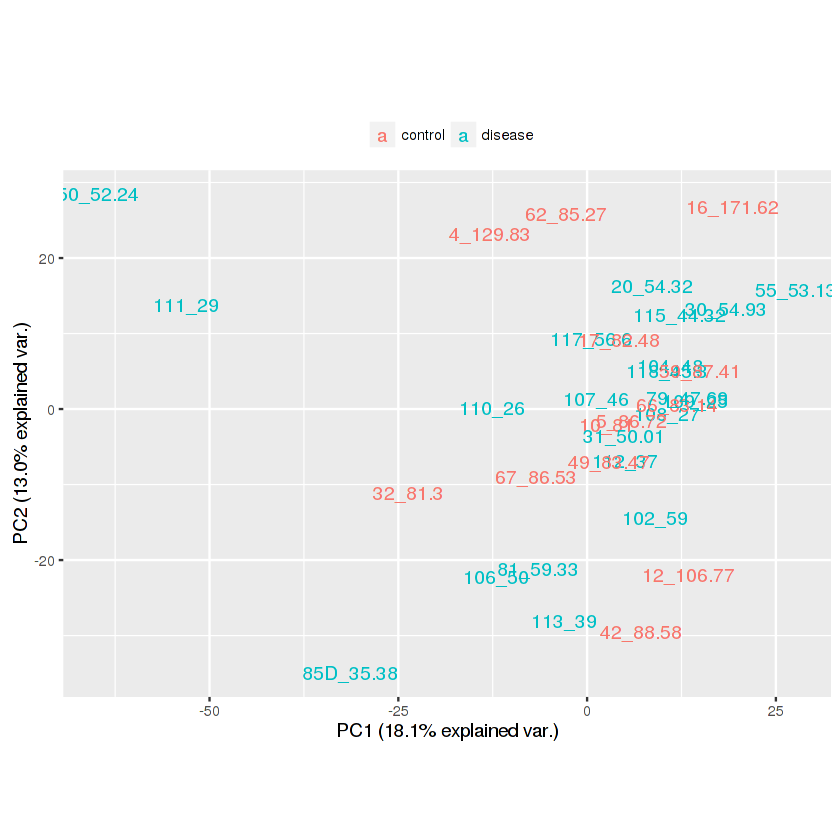

In [15]:
ir.pca <- prcomp(m_data_f_low %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 1:2, labels.size = 4,
              ellipse = F, circle = F, groups = micro_pheno$dlco_group,
              var.axes = F, labels = micro_pheno$ID)
              g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

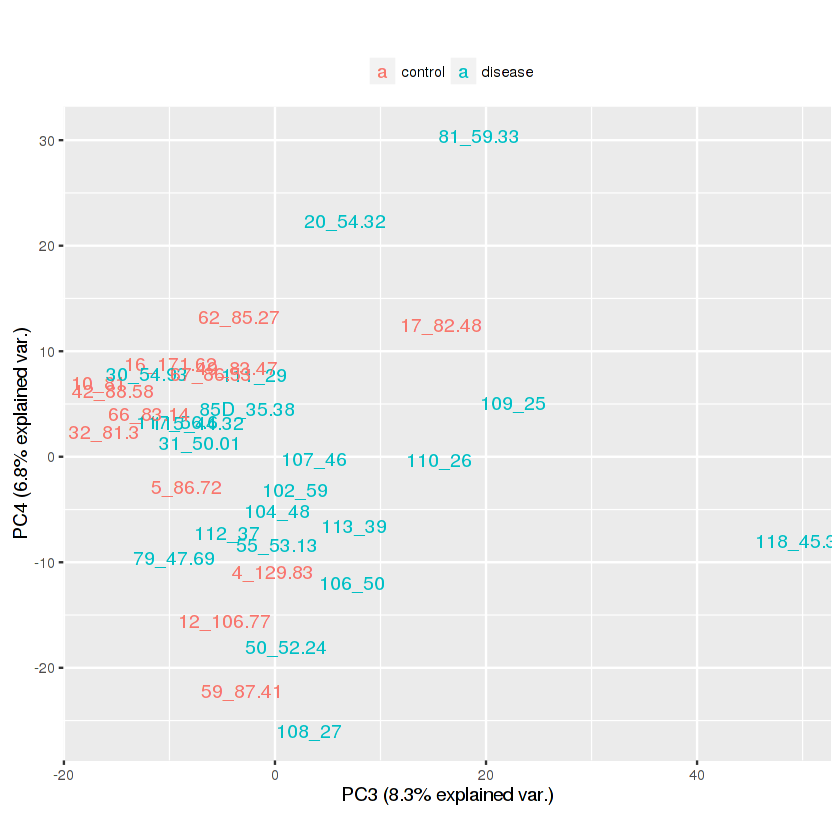

In [16]:
ir.pca <- prcomp(m_data_f_low %>% t)
#plot(ir.pca, type = "l")
g <- ggbiplot(ir.pca, obs.scale = 1, var.scale = 1, choices = 3:4, labels.size = 4,
              ellipse = F, circle = F, groups = micro_pheno$dlco_group,
              var.axes = F, labels = micro_pheno$ID)
              g <- g + scale_color_discrete(name = '')
g <- g + theme(legend.direction = 'horizontal',
               legend.position = 'top')
print(g)

# RankProd

In [17]:
toRP = m_data_f_low
toRP_classes = micro_pheno$dlco_group
RP.out <- RP(toRP ,toRP_classes, num.perm = 100, gene.names=row.names(toRP),
                logged = TRUE, na.rm = FALSE, plot = F, rand = 123) 

Rank Product analysis for two-class case 
 
 
Starting 100 permutations... 
Computing pfp .. 
Outputing the results .. 


In [18]:
  b <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table1 %>% as.data.frame %>% rownames_to_column(var = 'gene_symbol')
  a <- topGene(RP.out, cutoff = 0.05, logged = TRUE, method="pfp",
               gene.names=row.names(toRP), logbase = 2)$Table2 %>% as.data.frame %>% rownames_to_column(var = 'gene_symbol')
b %>% dim
a %>% dim
top_rankprod = b %>% bind_rows(a) %>% mutate(
    FC = ifelse(`FC:(class1/class2)` < 1, 1/`FC:(class1/class2)`, `FC:(class1/class2)`)) %>%
filter(FC > 1.5) %>% arrange(desc(FC))

write_csv(top_rankprod,'~/Downloads/tmp/top_rankprod_full_genes.csv')


# list of top microRNAs for enrichment with mirpath: http://snf-515788.vm.okeanos.grnet.gr/index.php?r=mirpath/index
write_csv(top_rankprod %>% dplyr::select(gene_symbol),'~/Downloads/tmp/top_rankprod_genes.csv', col_names = F)

top_rankprod %>% mutate(nn = nrow(.)) %>% head

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 

Table1: Genes called significant under class1 < class2 

Table2: Genes called significant under class1 > class2 



[1] 268   6

[1] 176   6

,gene_symbol,gene.index,RP/Rsum,FC:(class1/class2),pfp,P.value,FC,nn
1,DEFA1,2318,194.4324,0.3800,0,0,2.631579,100
2,MMP7,8436,244.9376,2.3289,0,0,2.328900,100
3,CCL19,2417,386.8861,0.4705,0,0,2.125399,100
4,IGHG3,9575,356.9994,0.4712,0,0,2.122241,100
5,CHIT1,9405,313.0966,0.4774,0,0,2.094680,100
6,RPS4Y1,417,355.1817,0.4808,0,0,2.079867,100


# heatmap

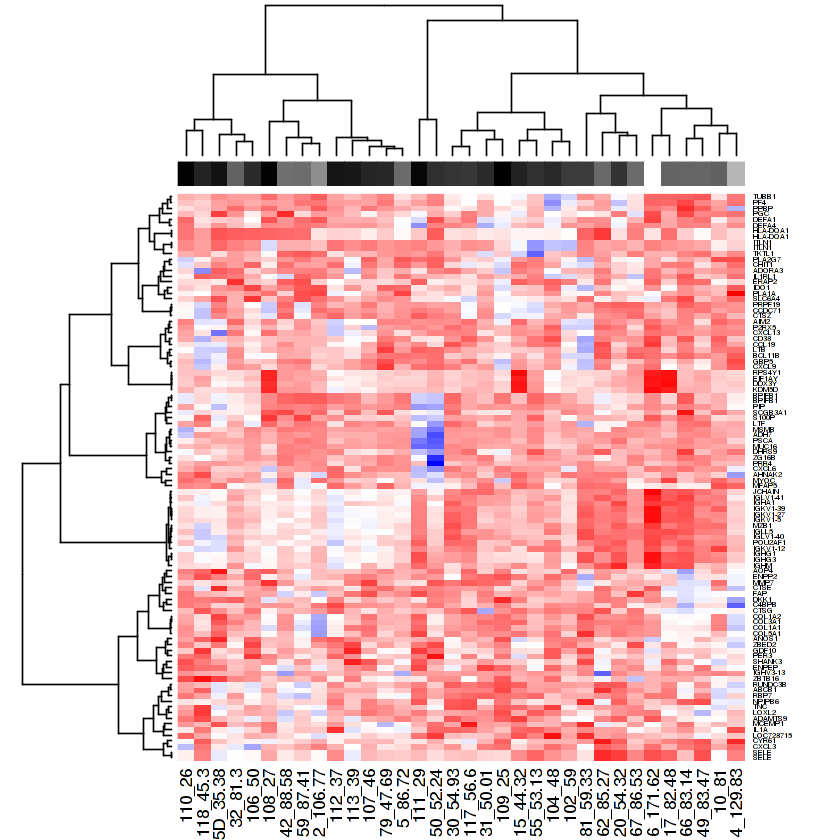

In [19]:
clust_methods = c("ward.D","ward.D2","single","complete","average","mcquitty","median","centroid")
dist.pear <- function(x) as.dist(1-cor(t(x)))
hclust.ave <- function(x) hclust(x, method=clust_methods[1])
hmcols<-colorRampPalette(c("red","white","blue"))(256)
hmcol<-brewer.pal(11,"RdBu")

var2 <- micro_pheno$dlco_group
var2 <- replace(var2, which(var2 == 'disease'), "magenta")
var2 <- replace(var2, which(var2 == 'control'), "deepskyblue")
    
heatmap(m_data_f_low[top_rankprod$gene_symbol,] %>% as.matrix, 
        #ColSideColors= var2, 
        ColSideColors= color.scale(micro_pheno$DLCO),
        col=hmcols, 
        distfun=dist.pear, hclustfun=hclust.ave,
        cexRow = 0.5,cexCol = 1.25)